In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

1. Eczema 1677
2. Melanoma 15.75k
3. Atopic Dermatitis - 1.25k
4. Basal Cell Carcinoma (BCC) 3323
5. Melanocytic Nevi (NV) - 7970
6. Benign Keratosis-like Lesions (BKL) 2624
7. Psoriasis pictures Lichen Planus and related diseases - 2k
8. Seborrheic Keratoses and other Benign Tumors - 1.8k
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
10. Warts Molluscum and other Viral Infections - 2103
11. Oily-Dry-Skin-Types

In [2]:
train_dir = 'content/skin-data/train'
test_dir = 'content/skin-data/test'
val_dir = 'content/skin-data/val'

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)



In [4]:
from PIL import Image

image_path = 'content/skin-data/test/1/t-03DermatitisArm.jpg'
image = Image.open(image_path)
width, height = image.size

print(f"이미지 크기: {width}x{height}")

이미지 크기: 720x472


In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # 이미지 크기 조정
    batch_size=16,
    class_mode='categorical'  # 다중 클래스 분류
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

Found 20679 images belonging to 11 classes.
Found 4100 images belonging to 11 classes.
Found 3984 images belonging to 11 classes.


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding="same"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding="same"),
    layers.MaxPooling2D((2, 2)),
    BatchNormalization()
])
# base_model.trainable = False


model = Sequential([
    model1,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(11, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 512)       1571904   
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 11)                5643      
                                                                 
Total params: 270015563 (1.01 GB)
Trainable params: 270012875 (1.01 GB)
Non-trainable params: 2688 (10.50 KB)
________

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     2

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',    # 'val_loss'를 기준으로 모니터링
    patience=2,            # 성능이 개선되지 않는 에포크 수 (기다리는 횟수)
    verbose=1,             # 출력 메시지 (1: 켜기, 0: 끄기)
    restore_best_weights=True # 최적의 가중치를 복원
)

In [10]:
# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping] # EarlyStopping
)
# 0.67 
# 0.69

Epoch 1/10


1292/1292 [==============================] - 13973s 11s/step - loss: 1.3602 - accuracy: 0.5396 - val_loss: 1.3312 - val_accuracy: 0.5491
Epoch 2/10
1292/1292 [==============================] - 13554s 10s/step - loss: 1.0601 - accuracy: 0.6129 - val_loss: 1.3837 - val_accuracy: 0.5251
Epoch 3/10
1292/1292 [==============================] - 14138s 11s/step - loss: 0.9617 - accuracy: 0.6456 - val_loss: 1.0410 - val_accuracy: 0.6296
Epoch 4/10
1292/1292 [==============================] - 14232s 11s/step - loss: 0.9091 - accuracy: 0.6626 - val_loss: 1.0833 - val_accuracy: 0.5986
Epoch 5/10
1292/1292 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.6761 

MemoryError: Unable to allocate 1.00 GiB for an array with shape (524288, 512) and data type float32

In [29]:
model.evaluate(test_generator)

249/249 [==============================] - 102s 411ms/step - loss: 0.8931 - accuracy: 0.6604


[0.8930880427360535, 0.6603915691375732]

In [19]:
history

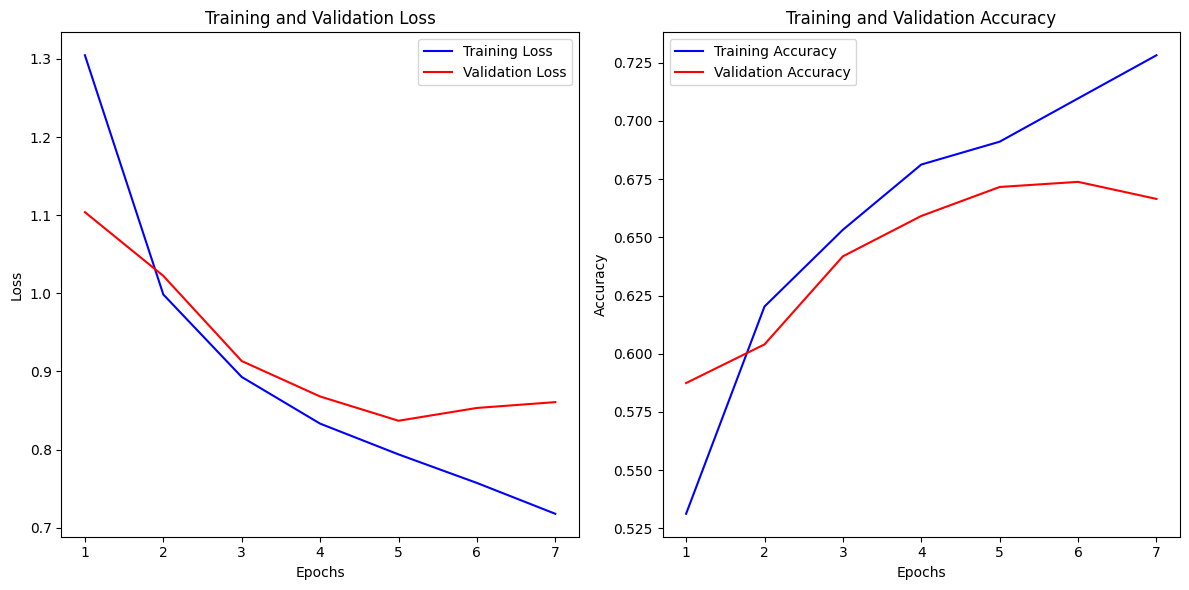

In [20]:
import matplotlib.pyplot as plt

# 학습 기록에서 손실과 정확도 데이터를 가져옴
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', None)
val_accuracy = history.history.get('val_accuracy', None)

epochs = range(1, len(loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 (정확도가 있는 경우만)
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
